### Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Функции для оптимизации

In [2]:
def reduction_memory(df: pd.DataFrame):
    """function for reduction memory size"""
    
    df_c = df.copy()
    
    for column in df_c.columns:
    
        series = df_c[column]
        
        if series.dtype == 'float64':
            if (series != series.astype('float32')).sum() == 0:
                df_c[column] = series.astype('float32')
        elif series.dtype == 'int64':
            if (series != series.astype('int8')).sum() == 0:
                df_c[column] = series.astype('int8')
            elif (series != series.astype('int16')).sum() == 0:
                df_c[column] = series.astype('int16')
            elif (series != series.astype('int32')).sum() == 0:
                df_c[column] = series.astype('int32')
                
    return df_c

## 1. Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

In [3]:
df_pjme_mw = pd.read_csv('my_PJME_MW.csv', index_col=0, parse_dates=['Date'])
df_pjme_mw = reduction_memory(df_pjme_mw)
df_pjme_mw[:2]

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0


In [4]:
df_pjme_mw_month = df_pjme_mw.resample(rule='M').mean()
df_pjme_mw_month[:2]

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-31,31075.400391,2002.0,1.0,16.020188,1.0,16.020188,2.873486,2.905787,11.515478,0.063257,0.032301,0.064603
2002-02-28,30239.166016,2002.0,2.0,14.500000,1.0,45.500000,7.071429,3.000000,11.500000,0.035714,0.035714,0.035714


## 2. Подберите параметры модели SARIMAX для этого ряда.

In [5]:
mod_serimax = sm.tsa.statespace.SARIMAX(df_pjme_mw_month['PJME_MW'], order=[2, 1, 1], 
                                        seasonal_order=[1, 2, 1, 20],
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)
result = mod_serimax.fit()
print(result.summary().tables[0], result.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                            PJME_MW   No. Observations:                  200
Model:             SARIMAX(2, 1, 1)x(1, 2, 1, 20)   Log Likelihood               -1286.336
Date:                            Wed, 04 Nov 2020   AIC                           2584.672
Time:                                    23:08:27   BIC                           2602.192
Sample:                                01-31-2002   HQIC                          2591.792
                                     - 08-31-2018                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

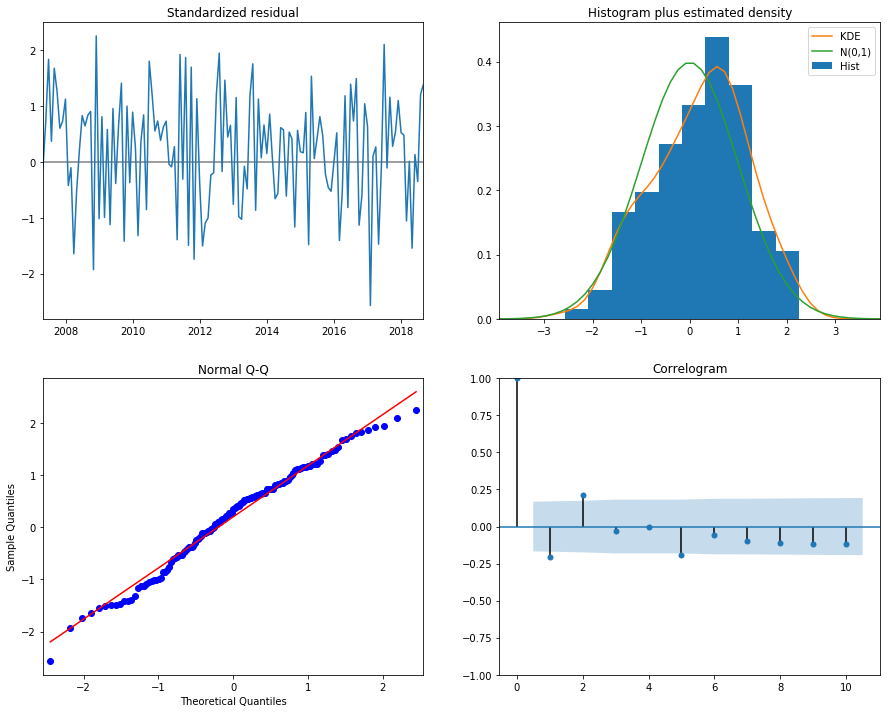

In [6]:
result.plot_diagnostics(figsize=(15, 12))
plt.show()

## 3. Сделайте вывод о том, как изменилась модель по сравнению с недельной.

In [7]:
df_pjme_mw_week = df_pjme_mw.resample(rule='W').mean()
df_pjme_mw_week[:2]

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-06,32392.160156,2002.0,1.0,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,0.0,0.167832
2002-01-13,31487.386719,2002.0,1.0,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,0.0,0.000000


In [8]:
mod_serimax = sm.tsa.statespace.SARIMAX(df_pjme_mw_week['PJME_MW'][:200], order=[1, 1, 0], 
                                        seasonal_order=[2, 2, 1, 10],
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)
result = mod_serimax.fit()
print(result.summary().tables[0], result.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                            PJME_MW   No. Observations:                  200
Model:             SARIMAX(1, 1, 0)x(2, 2, 1, 10)   Log Likelihood               -1484.188
Date:                            Wed, 04 Nov 2020   AIC                           2978.375
Time:                                    23:08:30   BIC                           2993.688
Sample:                                01-06-2002   HQIC                          2984.594
                                     - 10-30-2005                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

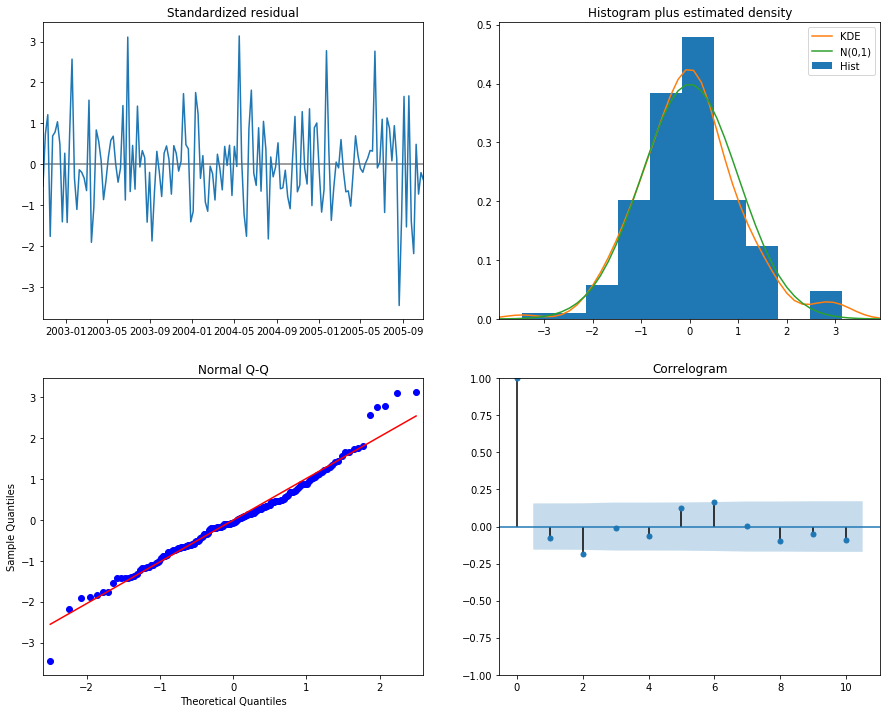

In [9]:
result.plot_diagnostics(figsize=(15, 12))
plt.show()

Для настройки моделей на разных ресемплингах необходимо подбирать разные настройки

##### Мелячная модель:
- arм.L2
- ma.L1
- ar.S.L20
- ma.S.L20

Гистограмма имеет больше колонок чем на недельной моделе, а так же на ней N(0,1) имеет смещение влево от KDE

##### Недельная модель:
- ar.L1
- ar.S.L20
- ma.S.L10

График нормали Q-Q имеет выбросы на концах

## 4. Постройте ACF, PACF и модель ARIMA для BRENT (lнедельный )

In [10]:
df_brent = pd.read_csv('my_BRENT2019.csv', index_col=0, parse_dates=[0])
df_brent = reduction_memory(df_brent)
df_brent[:2]

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0


In [11]:
df_brent_week = df_brent.resample('W').mean()
df_brent_week[:2]

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-05,76.616000,2010.0,9.0,3.0,3.0,246.0,35.0,4.0,0.000000,0.2,0.000000
2010-09-12,77.673333,2010.0,9.0,8.5,3.0,251.5,36.0,2.5,0.166667,0.0,0.166667


In [12]:
df_brent_week.shape[0]

470

In [13]:
model_arima = ARIMA(df_brent_week['Значение'], order=(0,0,0))
model_fit = model_arima.fit(disp=False)

y_p = model_fit.predict(df_brent_week.shape[0], df_brent_week.shape[0])

## 5. Оцените результат моделирования

## 6. Сделайте предположение о моделях, которые лучше работают с техниками регрессии на основе AR I MA.